In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import pickle

import optuna
from optuna.samplers import TPESampler

In [2]:
train_pickle = '../input/riiid-cross-validation-files/cv1_train.pickle'
valid_pickle = '../input/riiid-cross-validation-files/cv1_valid.pickle'
question_file = '../input/riiid-test-answer-prediction/questions.csv'
debug = False
validaten_flg = False
kaggle = True

In [3]:
def add_user_features(df, answer_sum_dict, answer_count_dict):
    answer_sum_series = np.zeros(len(df), dtype=np.int32)
    count_series = np.zeros(len(df), dtype=np.int32)
    
    for row_idx, item in enumerate(tqdm(df[['user_id', 'answered_correctly']].values)):
        answer_sum_series[row_idx] = answer_sum_dict[item[0]]
        count_series[row_idx] = answer_count_dict[item[0]]
         
        answer_sum_dict[item[0]] += item[1]
        answer_count_dict[item[0]] += 1
        
    user_features_df = pd.DataFrame({'answer_sum': answer_sum_series, 
                                     'answer_count': count_series})
    user_features_df['answer_c_avg'] = user_features_df['answer_sum'] / user_features_df['answer_count']
    df = pd.concat([df, user_features_df], axis=1)
    
    return df

In [4]:
def add_user_features_ignore_update(df, answer_sum_dict, answer_count_dict):
    answer_sum_series = np.zeros(len(df), dtype=np.int32)
    count_series = np.zeros(len(df), dtype=np.int32)
    
    for row_idx, item in enumerate(df[['user_id']].values):
        answer_sum_series[row_idx] = answer_sum_dict[item[0]]
        count_series[row_idx] = answer_count_dict[item[0]]
        
    user_features_df = pd.DataFrame({'answer_sum': answer_sum_series, 
                                     'answer_count': count_series})
    user_features_df['answer_c_avg'] = user_features_df['answer_sum'] / user_features_df['answer_count']
    df = pd.concat([df, user_features_df], axis=1)
    
    return df

In [5]:
def update_user_features(df, answer_sum_dict, answer_count_dict):
    for row in df.loc[df['content_type_id'] == 0, ['user_id', 'answered_correctly']].values:
        answer_sum_dict[row[0]] += row[1]
        answer_count_dict[row[0]] += 1

In [6]:
features = ['row_id', 'user_id', 'content_id', 
            'content_type_id', 'answered_correctly', 
            'prior_question_elapsed_time', 'prior_question_had_explanation']
train = pd.read_pickle(train_pickle)[features]
valid = pd.read_pickle(valid_pickle)[features]

if debug:
    train = train[:1000000]
    valid = valid[:10000]
if kaggle:
    train = train[-30000000:]
    
train = train.loc[train.content_type_id == 0].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == 0].reset_index(drop=True)

# content aggregate stat
content_agg = train[['content_id', 'answered_correctly']].groupby('content_id').agg(['sum', 'count', 'mean']).reset_index()
content_agg.columns = ['content_id', 'ac_content_sum', 'ac_content_count', 'ac_content_avg']

train = pd.merge(train, content_agg, on=['content_id'], how="left")
valid = pd.merge(valid, content_agg, on=['content_id'], how="left")

# user feature engineering with loops
answer_user_sum_dict = defaultdict(int)
answer_user_count_dict = defaultdict(int)
train = add_user_features(train, answer_user_sum_dict, answer_user_count_dict)
valid = add_user_features(valid, answer_user_sum_dict, answer_user_count_dict)

# fillna for prior_question_elapsed_time_mean
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean, inplace=True)
valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean, inplace=True)

# part
questions_df = pd.read_csv(question_file)
train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [7]:
target = 'answered_correctly'
Features = ['ac_content_sum', 'ac_content_count', 'ac_content_avg',
           'answer_c_avg', 'answer_count', 'answer_sum', 'part', 
            'prior_question_had_explanation', 'prior_question_elapsed_time']
drop_cols = list(set(train.columns) - set(Features))
y_tr = train[target]
y_va = valid[target]

train.drop(drop_cols, axis=1, inplace=True)
valid.drop(drop_cols, axis=1, inplace=True)
_=gc.collect()

In [8]:
lgb_train = lgb.Dataset(train[Features], label = y_tr)
lgb_valid = lgb.Dataset(valid[Features], label = y_va)
del train, y_tr
_=gc.collect()

In [9]:
params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80,
    'num_iterations': 1000
}

In [10]:
model = lgb.train(
                    params, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=10000,
                    early_stopping_rounds=10
                )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.751809	valid_1's auc: 0.756777
[200]	training's auc: 0.752561	valid_1's auc: 0.757474
[300]	training's auc: 0.752874	valid_1's auc: 0.757702
[400]	training's auc: 0.753123	valid_1's auc: 0.757858
[500]	training's auc: 0.753376	valid_1's auc: 0.757999
[600]	training's auc: 0.753564	valid_1's auc: 0.758077
[700]	training's auc: 0.753733	valid_1's auc: 0.758156
[800]	training's auc: 0.753895	valid_1's auc: 0.758214
[900]	training's auc: 0.754055	valid_1's auc: 0.758281
[1000]	training's auc: 0.754181	valid_1's auc: 0.758319
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.754181	valid_1's auc: 0.758319


auc: 0.7583187798329882


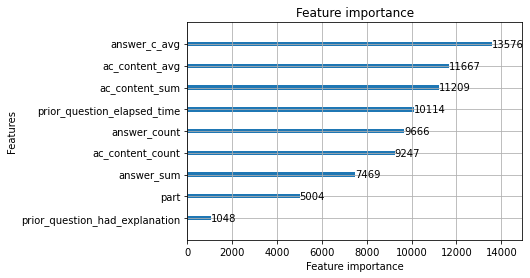

In [11]:
print('auc:', roc_auc_score(y_va, model.predict(valid[Features])))
_ = lgb.plot_importance(model)

In [12]:
model.save_model('/kaggle/output/model.txt')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/output/model.txt'

# Inference

In [13]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()
set_predict = env.predict

In [14]:
previous_test_df = None
for (test_df, sample_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df[target] = eval(test_df["prior_group_answers_correct"].iloc[0])
        update_user_features(previous_test_df, answer_user_sum_dict, answer_user_count_dict)
    previous_test_df = test_df.copy()
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = add_user_features_ignore_update(test_df, answer_user_sum_dict, answer_user_count_dict)
    test_df = test_df.merge(content_agg, on='content_id',  how="left")
    test_df = test_df.merge(questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
    test_df.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean, inplace=True)    
    test_df[target] = model.predict(test_df[Features])
    set_predict(test_df[['row_id', target]])